In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import pylustrator

In [15]:
LOG_PATH = "../logs/overhead/"
NU_SOCIALNET_LOG_PATH = LOG_PATH + "nu_socialnet/"

In [16]:
import glob

# Grab all files that follow the pattern DDB_DISABLE.* from NU_SOCIALNET_LOG_PATH
files = glob.glob(NU_SOCIALNET_LOG_PATH + "DDB_DISABLE.*")
pprint(files)

['../logs/overhead/nu_socialnet/DDB_DISABLE.5.8',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.2.9',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.3.9',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.4.8',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.6.8',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.1.9',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.7.8',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.2.10',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.3.8',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.3.10',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.4.9',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.1.10',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.5.9',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.2.8',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.4.10',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.5.10',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.7.9',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.6.9',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.7.10',
 '../logs/overhead/nu_socialnet/DDB_DISABLE.

In [17]:
from dataclasses import dataclass
@dataclass
class Metric:
    label: str


In [18]:
data = []

In [19]:
def extract_data(match: str, embed: bool, debugger: str):
    # from 1 server to 7 servers setup
    for i in range(1, 8):
        files = glob.glob(NU_SOCIALNET_LOG_PATH + f"{match}.{i}.*")
        mops = 0
        avg_lat_sum = 0
        lat_p50_sum = 0
        lat_p90_sum = 0
        lat_p95_sum = 0
        lat_p99_sum = 0
        for file in files:
            with open(file, 'r') as f:
                lines = f.readlines()
                if lines:
                    # print(lines[-1].strip())
                    line_d = lines[-1].strip().split()
                    mops += float(line_d[0])
                    avg_lat_sum += int(line_d[1])
                    lat_p50_sum += int(line_d[2])
                    lat_p90_sum += int(line_d[3])
                    lat_p95_sum += int(line_d[4])
                    lat_p99_sum += int(line_d[5])
        avg_lat = avg_lat_sum / len(files)
        lat_p50 = lat_p50_sum / len(files)
        lat_p90 = lat_p90_sum / len(files)
        lat_p95 = lat_p95_sum / len(files)
        lat_p99 = lat_p99_sum / len(files)
        # print(f"i: {i}, mops: {mops}")
        data.append(
            {
                "servers": i,
                "mops": mops,
                "avg_lat": avg_lat,
                "lat_p50": lat_p50,
                "lat_p90": lat_p90,
                "lat_p95": lat_p95,
                "lat_p99": lat_p99,
                "embed": embed,
                "debugger": debugger
            }
        )

In [20]:
extract_data("DDB_DISABLE", False, "none")
extract_data("DDB_ENABLE", True, "none")
extract_data("gdb.DDB_DISABLE", False, "gdb")
extract_data("ddb.DDB_ENABLE", True, "ddb")

In [21]:
df = pd.DataFrame(data)
df.head()

,servers,mops,avg_lat,lat_p50,lat_p90,lat_p95,lat_p99,embed,debugger
0,1,0.682270,777.666667,104.333333,473.333333,927.000000,19229.666667,False,none
1,2,0.977922,607.000000,233.666667,840.666667,1357.333333,9835.666667,False,none
2,3,1.338838,447.000000,305.333333,949.666667,1335.000000,2554.000000,False,none
3,4,1.649158,363.000000,212.333333,754.666667,1197.333333,2815.000000,False,none
4,5,1.945979,307.333333,194.666667,655.333333,989.666667,1939.666667,False,none


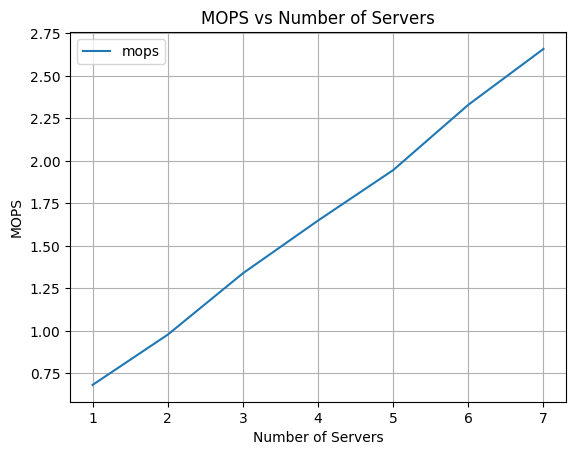

In [22]:
filtered_df = df.query('embed == False and debugger == "none"')
filtered_df
filtered_df.plot(x='servers', y='mops', kind='line')
plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.grid(True)
plt.show()

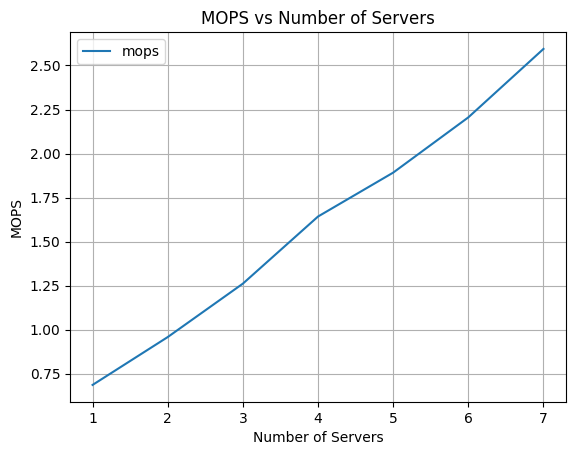

In [23]:
filtered_df = df.query('embed == True and debugger == "none"')
filtered_df
filtered_df.plot(x='servers', y='mops', kind='line')
plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.grid(True)
plt.show()

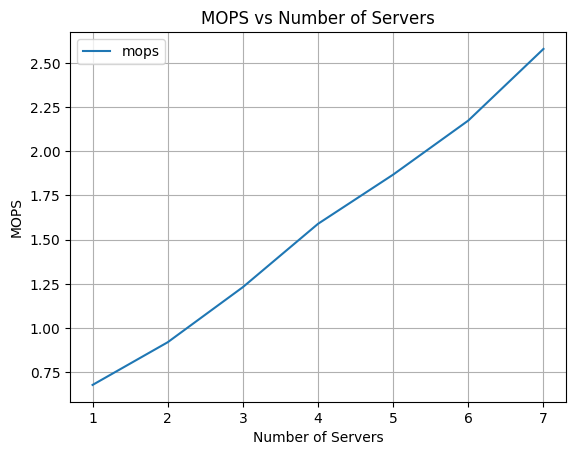

In [24]:
filtered_df = df.query('embed == True and debugger == "ddb"')
filtered_df
filtered_df.plot(x='servers', y='mops', kind='line')
plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.grid(True)
plt.show()

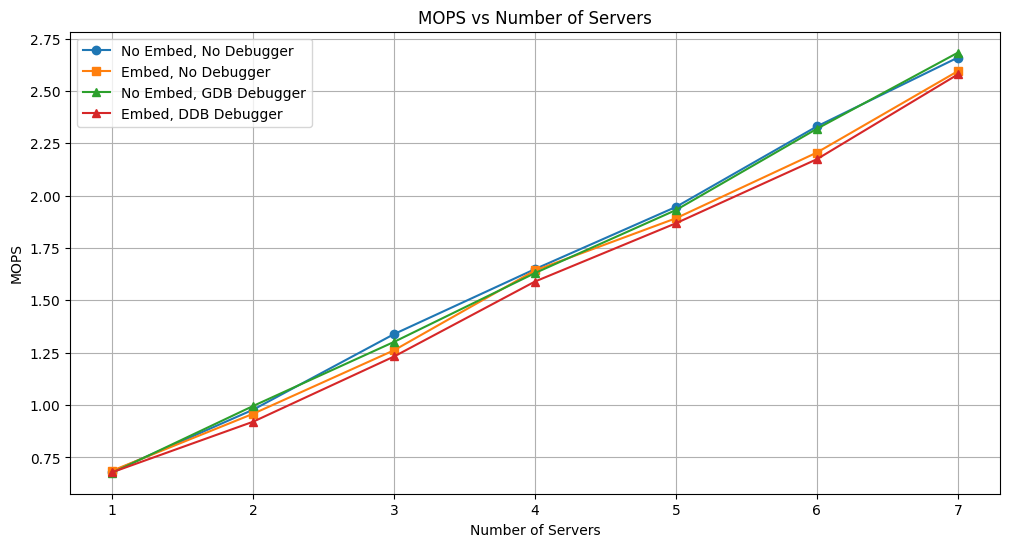

In [25]:
# plt.style.use('fivethirtyeight')
plt.style.use('default')
plt.figure(figsize=(12, 6))
# plt.figure(figsize=(12, 6))

# Plot for embed == False and debugger == "none"
filtered_df = df.query('embed == False and debugger == "none"')
plt.plot(filtered_df['servers'], filtered_df['mops'], label='No Embed, No Debugger', marker='o')
# plt.scatter(filtered_df['servers'], filtered_df['mops'], marker='o')

# Plot for embed == True and debugger == "none"
filtered_df = df.query('embed == True and debugger == "none"')
plt.plot(filtered_df['servers'], filtered_df['mops'], label='Embed, No Debugger', marker='s')
# plt.scatter(filtered_df['servers'], filtered_df['mops'], marker='s')

filtered_df = df.query('embed == False and debugger == "gdb"')
plt.plot(filtered_df['servers'], filtered_df['mops'], label='No Embed, GDB Debugger', marker='^')

filtered_df = df.query('embed == True and debugger == "ddb"')
plt.plot(filtered_df['servers'], filtered_df['mops'], label='Embed, DDB Debugger', marker='^')


plt.xlabel('Number of Servers')
plt.ylabel('MOPS')
plt.title('MOPS vs Number of Servers')
plt.legend()
plt.grid(True)
plt.show()